In [18]:
import pandas as pd
import os

df = pd.read_csv("../data/transformado/quejas_features.csv")

X = df.drop(columns=["Consumer_disputed", "target_disputed", "Timely_response"])
y_disputed = df["target_disputed"]
y_timely = df["Timely_response"]

INTERIM_DIR = "../models/data/"
os.makedirs(INTERIM_DIR, exist_ok=True)

X.to_csv(os.path.join(INTERIM_DIR, "X_features.csv"), index=False)
y_disputed.to_csv(os.path.join(INTERIM_DIR, "y_disputed.csv"), index=False)
y_timely.to_csv(os.path.join(INTERIM_DIR, "y_timely.csv"), index=False)


In [19]:
X = pd.read_csv("../models/data/X_features.csv")
y_disputed = pd.read_csv("../models/data/y_disputed.csv").squeeze("columns").astype(int)
y_timely = pd.read_csv("../models/data/y_timely.csv").squeeze("columns").astype(int)

X.shape, y_disputed.shape, y_timely.shape, y_disputed.mean(), y_timely.mean()


((28156, 15),
 (28156,),
 (28156,),
 np.float64(0.16717573518965761),
 np.float64(0.9747123170904958))

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split

idx = np.arange(len(X))
X_train, X_test, y2_train, y2_test, idx_train, idx_test = train_test_split(
    X, y_disputed, idx, test_size=0.2, stratify=y_disputed, random_state=42
)

y1_train = y_timely.iloc[idx_train].reset_index(drop=True)
y1_test = y_timely.iloc[idx_test].reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y2_train = y2_train.reset_index(drop=True)
y2_test = y2_test.reset_index(drop=True)

X_train.shape, X_test.shape, y2_train.mean(), y2_test.mean(), y1_train.mean(), y1_test.mean()


((22524, 15),
 (5632, 15),
 np.float64(0.16715503462972828),
 np.float64(0.16725852272727273),
 np.float64(0.9742940863079382),
 np.float64(0.9763849431818182))

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_cols = [
    "Product","Sub_product","Issue","Sub_issue","State","Company",
    "Company_response","Company_grouped","Days_to_response_bin","ZIP_code"
]
numeric_cols = ["Days_to_response","Issue_len","Sub_issue_words"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

preprocessor


,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,False


LogisticRegression_balanced
accuracy: 0.6884 precision: 0.2579 recall: 0.4597 f1: 0.3304 roc_auc: 0.6656
[[3444 1246]
 [ 509  433]]


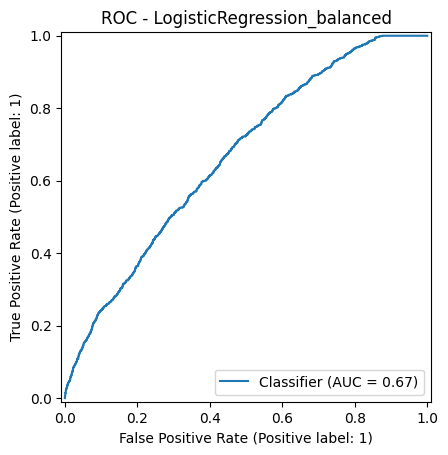

,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_balanced,0.688388,0.257892,0.45966,0.330408,0.665615


In [23]:

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, RocCurveDisplay

def train_eval(clf, name):
    pipe = Pipeline([("pre", preprocessor), ("clf", clf)])
    pipe.fit(X_train, y2_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe.named_steps["clf"],"predict_proba") else None
    acc = accuracy_score(y2_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y2_test, y_pred, average="binary", zero_division=0)
    auc = roc_auc_score(y2_test, y_proba) if y_proba is not None else np.nan
    cm = confusion_matrix(y2_test, y_pred)
    print(name)
    print("accuracy:", round(acc,4), "precision:", round(prec,4), "recall:", round(rec,4), "f1:", round(f1,4), "roc_auc:", round(auc,4))
    print(cm)
    if y_proba is not None:
        RocCurveDisplay.from_predictions(y2_test, y_proba)
        plt.title(f"ROC - {name}")
        plt.show()
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc, "pipeline": pipe}

results = []
res_lr = train_eval(LogisticRegression(max_iter=2000, class_weight="balanced"), "LogisticRegression_balanced")
results.append({k:v for k,v in res_lr.items() if k!="pipeline"})
results_df = pd.DataFrame(results).sort_values("f1", ascending=False)
results_df


In [25]:
import joblib, os

# Guardar el pipeline en un pkl
os.makedirs("../models", exist_ok=True)
joblib.dump(res_lr["pipeline"], "../models/trained_model_LogisticRegression_balanced.pkl")



['../models/trained_model_LogisticRegression_balanced.pkl']

Accuracy = 0.688: parece bueno, pero está sesgado por el desbalance (la mayoría son “no disputa”).

Recall = 0.459: el modelo logra identificar ~46% de las disputas reales → importante, porque en negocio interesa no perder disputas.

Precision = 0.258: de cada 10 predicciones de “sí disputa”, solo 2-3 son correctas.

F1 = 0.33: moderado, refleja el compromiso entre precisión y recall.

ROC-AUC = 0.66: el modelo tiene poder predictivo, pero aún bajo.

Interpretación de negocio

✅ El modelo detecta casi la mitad de las disputas (recall aceptable como baseline).
⚠️ Pero genera muchos falsos positivos: marcaría muchos casos como disputa cuando no lo son.
👉 Esto no es catastrófico: en negocio es preferible sobre-alertar que dejar disputas sin atender, pero debemos mejorar con modelos más potentes (árboles, boosting).

RandomForest_balanced
accuracy: 0.8315 precision: 0.4507 recall: 0.034 f1: 0.0632 roc_auc: 0.6384
[[4651   39]
 [ 910   32]]


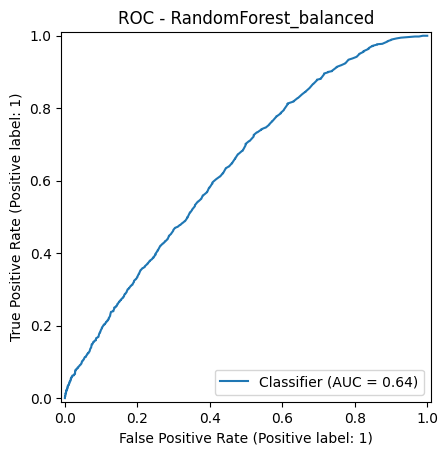

,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_balanced,0.688388,0.257892,0.45966,0.330408,0.665615
1,RandomForest_balanced,0.831499,0.450704,0.03397,0.063179,0.638395


In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=1,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42
)

res_rf = train_eval(rf, "RandomForest_balanced")
results.append({k:v for k,v in res_rf.items() if k!="pipeline"})
rf_pipe = res_rf["pipeline"]
results_df = pd.DataFrame(results).sort_values("f1", ascending=False)
results_df


In [27]:
os.makedirs("../models", exist_ok=True)
joblib.dump(rf_pipe, "../models/trained_model_RandomForest_balanced.pkl")


['../models/trained_model_RandomForest_balanced.pkl']

In [ ]:
#!pip install imbalanced-learn


RandomForest_SMOTE
accuracy: 0.8248 precision: 0.3448 recall: 0.0531 f1: 0.092 roc_auc: 0.6287
[[4595   95]
 [ 892   50]]


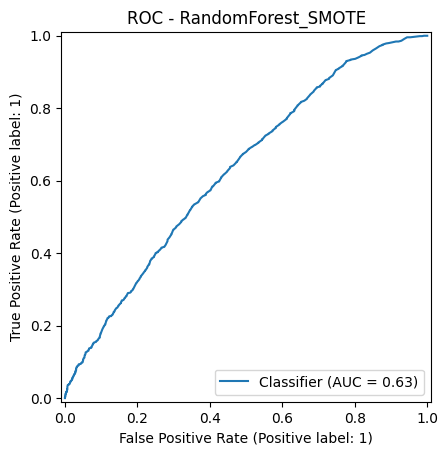

,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_balanced,0.688388,0.257892,0.459660,0.330408,0.665615
2,RandomForest_SMOTE,0.824751,0.344828,0.053079,0.091996,0.628707
1,RandomForest_balanced,0.831499,0.450704,0.033970,0.063179,0.638395


In [28]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

smote_rf = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))
])

smote_rf.fit(X_train, y2_train)
y_pred = smote_rf.predict(X_test)
y_proba = smote_rf.predict_proba(X_test)[:,1]
acc = accuracy_score(y2_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y2_test, y_pred, average="binary", zero_division=0)
auc = roc_auc_score(y2_test, y_proba)
cm = confusion_matrix(y2_test, y_pred)

print("RandomForest_SMOTE")
print("accuracy:", round(acc,4), "precision:", round(prec,4), "recall:", round(rec,4), "f1:", round(f1,4), "roc_auc:", round(auc,4))
print(cm)
RocCurveDisplay.from_predictions(y2_test, y_proba)
plt.title("ROC - RandomForest_SMOTE")
plt.show()

results.append({"model":"RandomForest_SMOTE","accuracy":acc,"precision":prec,"recall":rec,"f1":f1,"roc_auc":auc})
results_df = pd.DataFrame(results).sort_values("f1", ascending=False)
results_df


In [29]:
os.makedirs("../models", exist_ok=True)
joblib.dump(smote_rf, "../models/trained_model_RandomForest_SMOTE.pkl")


['../models/trained_model_RandomForest_SMOTE.pkl']

👉 Cómo leer tus resultados:

Accuracy (82% en ambos) es alto porque la mayoría de los casos son “no disputa” → el modelo acierta mucho prediciendo la clase mayoritaria.

Recall es el punto débil:

RF balanced: 0.03 (solo detecta ~3% de disputas).

RF SMOTE: 0.05 (algo mejor, pero aún muy bajo).

Precision también es baja (0.34–0.45), lo que significa que, de las pocas disputas que predice, muchas son falsas.

ROC-AUC (~0.63) indica que el modelo apenas discrimina mejor que el azar (0.5).

📌 Conclusión rápida:

El Random Forest es muy conservador y casi siempre predice “no disputa”.

Aunque mejora en accuracy, no sirve bien si tu cliente necesita detectar disputas reales (recall).

El Logistic Regression balanceado tiene un recall mucho mejor (0.46), aunque sacrifica algo de precisión.

XGB_scale_pos_weight
accuracy: 0.5785 precision: 0.235 recall: 0.6741 f1: 0.3485 roc_auc: 0.6667
[[2623 2067]
 [ 307  635]]


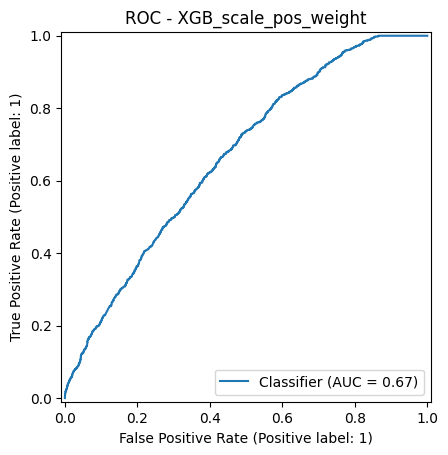

,model,accuracy,precision,recall,f1,roc_auc
5,XGB_scale_pos_weight,0.578480,0.235011,0.674098,0.348518,0.666711
0,LogisticRegression_balanced,0.688388,0.257892,0.459660,0.330408,0.665615
2,RandomForest_SMOTE,0.824751,0.344828,0.053079,0.091996,0.628707
3,XGB_SMOTE,0.829190,0.409091,0.047771,0.085551,0.661045
1,RandomForest_balanced,0.831499,0.450704,0.033970,0.063179,0.638395
4,LinearSVC_calibrated,0.832741,0.000000,0.000000,0.000000,0.648865


In [36]:
from xgboost import XGBClassifier

pos = y2_train.sum()
neg = len(y2_train) - pos
spw = neg / pos

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    scale_pos_weight=spw,
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1
)

res_xgb = train_eval(xgb, "XGB_scale_pos_weight")
results.append({k:v for k,v in res_xgb.items() if k!="pipeline"})
xgb_pipe = res_xgb["pipeline"]
results_df = pd.DataFrame(results).sort_values("f1", ascending=False)
results_df


In [37]:
results_df

,model,accuracy,precision,recall,f1,roc_auc
5,XGB_scale_pos_weight,0.578480,0.235011,0.674098,0.348518,0.666711
0,LogisticRegression_balanced,0.688388,0.257892,0.459660,0.330408,0.665615
2,RandomForest_SMOTE,0.824751,0.344828,0.053079,0.091996,0.628707
3,XGB_SMOTE,0.829190,0.409091,0.047771,0.085551,0.661045
1,RandomForest_balanced,0.831499,0.450704,0.033970,0.063179,0.638395
4,LinearSVC_calibrated,0.832741,0.000000,0.000000,0.000000,0.648865


In [38]:
os.makedirs("../models", exist_ok=True)
joblib.dump(xgb_pipe, "../models/trained_model_XGB_scale_pos_weight.pkl")


['../models/trained_model_XGB_scale_pos_weight.pkl']

XGB_SMOTE
accuracy: 0.8292 precision: 0.4091 recall: 0.0478 f1: 0.0856 roc_auc: 0.661
[[4625   65]
 [ 897   45]]


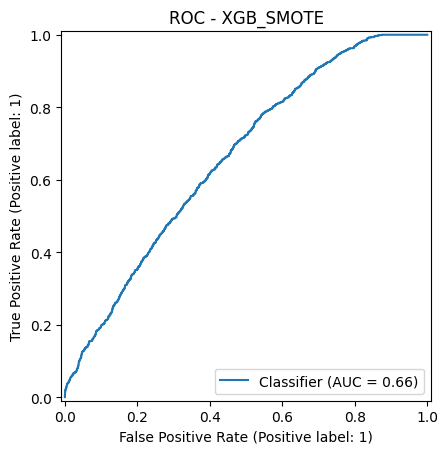

,model,accuracy,precision,recall,f1,roc_auc
5,XGB_scale_pos_weight,0.578480,0.235011,0.674098,0.348518,0.666711
0,LogisticRegression_balanced,0.688388,0.257892,0.459660,0.330408,0.665615
2,RandomForest_SMOTE,0.824751,0.344828,0.053079,0.091996,0.628707
6,XGB_SMOTE,0.829190,0.409091,0.047771,0.085551,0.661045
3,XGB_SMOTE,0.829190,0.409091,0.047771,0.085551,0.661045
1,RandomForest_balanced,0.831499,0.450704,0.033970,0.063179,0.638395
4,LinearSVC_calibrated,0.832741,0.000000,0.000000,0.000000,0.648865


In [39]:

smote_xgb = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", XGBClassifier(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        eval_metric="logloss",
        n_jobs=-1
    ))
])

smote_xgb.fit(X_train, y2_train)
y_pred = smote_xgb.predict(X_test)
y_proba = smote_xgb.predict_proba(X_test)[:,1]
acc = accuracy_score(y2_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y2_test, y_pred, average="binary", zero_division=0)
auc = roc_auc_score(y2_test, y_proba)
cm = confusion_matrix(y2_test, y_pred)

print("XGB_SMOTE")
print("accuracy:", round(acc,4), "precision:", round(prec,4), "recall:", round(rec,4), "f1:", round(f1,4), "roc_auc:", round(auc,4))
print(cm)
RocCurveDisplay.from_predictions(y2_test, y_proba)
plt.title("ROC - XGB_SMOTE")
plt.show()

results.append({"model":"XGB_SMOTE","accuracy":acc,"precision":prec,"recall":rec,"f1":f1,"roc_auc":auc})
results_df = pd.DataFrame(results).sort_values("f1", ascending=False)
results_df


In [40]:
os.makedirs("../models", exist_ok=True)
joblib.dump(smote_xgb, "../models/trained_model_XGB_SMOTE.pkl")


['../models/trained_model_XGB_SMOTE.pkl']

LinearSVC_calibrated
accuracy: 0.8327 precision: 0.0 recall: 0.0 f1: 0.0 roc_auc: 0.6489
[[4690    0]
 [ 942    0]]


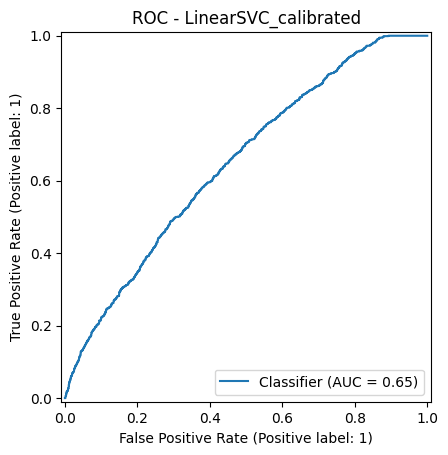

,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_balanced,0.688388,0.257892,0.459660,0.330408,0.665615
2,RandomForest_SMOTE,0.824751,0.344828,0.053079,0.091996,0.628707
3,XGB_SMOTE,0.829190,0.409091,0.047771,0.085551,0.661045
1,RandomForest_balanced,0.831499,0.450704,0.033970,0.063179,0.638395
4,LinearSVC_calibrated,0.832741,0.000000,0.000000,0.000000,0.648865


In [33]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

lin = LinearSVC(class_weight="balanced", max_iter=5000)
svm_lin = CalibratedClassifierCV(lin, method="sigmoid", cv=3)
res_svm_lin = train_eval(svm_lin, "LinearSVC_calibrated")
results.append({k:v for k,v in res_svm_lin.items() if k!="pipeline"})
pd.DataFrame(results).sort_values("f1", ascending=False)


In [34]:
os.makedirs("../models", exist_ok=True)
joblib.dump(res_svm_lin["pipeline"], "../models/trained_model_LinearSVC_calibrated.pkl")


['../models/trained_model_LinearSVC_calibrated.pkl']

KNN_k25_distance
accuracy: 0.8319 precision: 0.4242 recall: 0.0149 f1: 0.0287 roc_auc: 0.6127
[[4671   19]
 [ 928   14]]


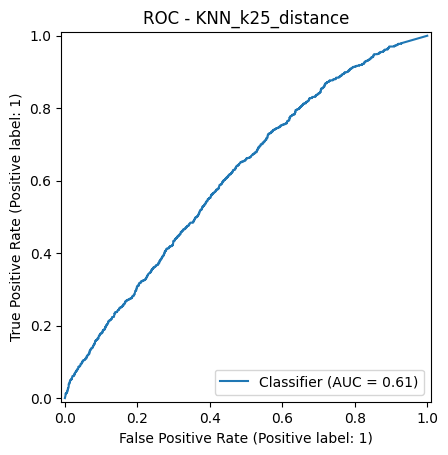

,model,accuracy,precision,recall,f1,roc_auc
5,XGB_scale_pos_weight,0.578480,0.235011,0.674098,0.348518,0.666711
0,LogisticRegression_balanced,0.688388,0.257892,0.459660,0.330408,0.665615
2,RandomForest_SMOTE,0.824751,0.344828,0.053079,0.091996,0.628707
3,XGB_SMOTE,0.829190,0.409091,0.047771,0.085551,0.661045
6,XGB_SMOTE,0.829190,0.409091,0.047771,0.085551,0.661045
1,RandomForest_balanced,0.831499,0.450704,0.033970,0.063179,0.638395
7,KNN_k25_distance,0.831854,0.424242,0.014862,0.028718,0.612661
4,LinearSVC_calibrated,0.832741,0.000000,0.000000,0.000000,0.648865


In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=25, weights="distance", n_jobs=-1)
res_knn = train_eval(knn, "KNN_k25_distance")
results.append({k:v for k,v in res_knn.items() if k!="pipeline"})
knn_pipe = res_knn["pipeline"]
results_df = pd.DataFrame(results).sort_values("f1", ascending=False)
results_df


In [42]:
os.makedirs("../models", exist_ok=True)
joblib.dump(knn_pipe, "../models/trained_model_KNN_k25_distance.pkl")


['../models/trained_model_KNN_k25_distance.pkl']

In [43]:
results_df = pd.DataFrame(results).drop_duplicates(subset=["model"]).sort_values("f1", ascending=False)
results_df


,model,accuracy,precision,recall,f1,roc_auc
5,XGB_scale_pos_weight,0.578480,0.235011,0.674098,0.348518,0.666711
0,LogisticRegression_balanced,0.688388,0.257892,0.459660,0.330408,0.665615
2,RandomForest_SMOTE,0.824751,0.344828,0.053079,0.091996,0.628707
3,XGB_SMOTE,0.829190,0.409091,0.047771,0.085551,0.661045
1,RandomForest_balanced,0.831499,0.450704,0.033970,0.063179,0.638395
7,KNN_k25_distance,0.831854,0.424242,0.014862,0.028718,0.612661
4,LinearSVC_calibrated,0.832741,0.000000,0.000000,0.000000,0.648865


In [45]:
# Limpiar duplicados y ordenar
results_df = pd.DataFrame(results).drop_duplicates(subset=["model"]).sort_values("f1", ascending=False)

# Guardar tabla de resultados del problema de disputa
os.makedirs("../models", exist_ok=True)
results_df.to_csv("../models/results_disputed_models.csv", index=False)

results_df


,model,accuracy,precision,recall,f1,roc_auc
5,XGB_scale_pos_weight,0.578480,0.235011,0.674098,0.348518,0.666711
0,LogisticRegression_balanced,0.688388,0.257892,0.459660,0.330408,0.665615
2,RandomForest_SMOTE,0.824751,0.344828,0.053079,0.091996,0.628707
3,XGB_SMOTE,0.829190,0.409091,0.047771,0.085551,0.661045
1,RandomForest_balanced,0.831499,0.450704,0.033970,0.063179,0.638395
7,KNN_k25_distance,0.831854,0.424242,0.014862,0.028718,0.612661
4,LinearSVC_calibrated,0.832741,0.000000,0.000000,0.000000,0.648865



1. **XGB (scale\_pos\_weight)**

   * Recall = **0.67** → el que **mejor detecta disputas**, aunque baja Accuracy (0.57).
   * Esto indica que está sacrificando muchos "no disputados" para atrapar disputas.

2. **Logistic Regression (balanced)**

   * Balance decente: Recall = 0.46, AUC ≈ 0.66.
   * Menor accuracy, pero un baseline muy sólido.

3. **Random Forest / KNN / SVC**

   * Accuracy muy alta (≈0.83), pero **recall casi nulo**.
   * Detectan bien los "no disputados", pero casi nunca marcan disputas → poco útil para negocio.

4. **XGB\_SMOTE / RF\_SMOTE**

   * Ligeramente mejor que RF puro, pero recall sigue muy bajo.


### 🎯 Interpretación de negocio

* Para el **cliente**, lo crítico es **detectar disputas a tiempo** (mejor tener falsos positivos que perder disputas).

* Por eso, el modelo que más valor aporta ahora mismo es:
  👉 **XGB con scale\_pos\_weight**, porque aunque tiene menor accuracy, sí logra capturar **2 de cada 3 disputas**.

* Logistic Regression también es un buen **baseline explicable**.



XGB_calibrated_isotonic
accuracy: 0.8347 precision: 0.6897 recall: 0.0212 f1: 0.0412 roc_auc: 0.6681
[[4681    9]
 [ 922   20]]


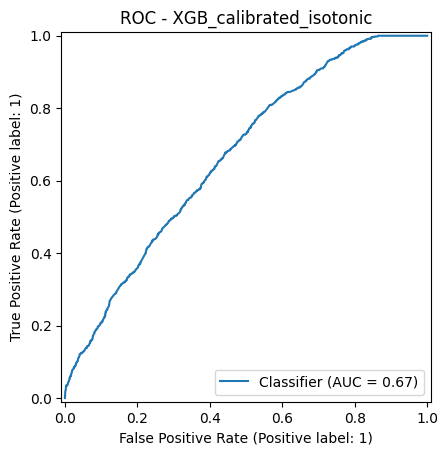

,model,accuracy,precision,recall,f1,roc_auc
5,XGB_scale_pos_weight,0.578480,0.235011,0.674098,0.348518,0.666711
0,LogisticRegression_balanced,0.688388,0.257892,0.459660,0.330408,0.665615
2,RandomForest_SMOTE,0.824751,0.344828,0.053079,0.091996,0.628707
3,XGB_SMOTE,0.829190,0.409091,0.047771,0.085551,0.661045
1,RandomForest_balanced,0.831499,0.450704,0.033970,0.063179,0.638395
8,XGB_calibrated_isotonic,0.834695,0.689655,0.021231,0.041195,0.668135
7,KNN_k25_distance,0.831854,0.424242,0.014862,0.028718,0.612661
4,LinearSVC_calibrated,0.832741,0.000000,0.000000,0.000000,0.648865


In [46]:

pos = y2_train.sum()
neg = len(y2_train) - pos
spw = neg / pos

xgb_base = Pipeline([
    ("pre", preprocessor),
    ("clf", XGBClassifier(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        scale_pos_weight=spw,
        random_state=42,
        eval_metric="logloss",
        n_jobs=-1
    ))
])

xgb_cal = CalibratedClassifierCV(xgb_base, method="isotonic", cv=3)
xgb_cal.fit(X_train, y2_train)
y_pred = xgb_cal.predict(X_test)
y_proba = xgb_cal.predict_proba(X_test)[:,1]
acc = accuracy_score(y2_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y2_test, y_pred, average="binary", zero_division=0)
auc = roc_auc_score(y2_test, y_proba)
cm = confusion_matrix(y2_test, y_pred)

print("XGB_calibrated_isotonic")
print("accuracy:", round(acc,4), "precision:", round(prec,4), "recall:", round(rec,4), "f1:", round(f1,4), "roc_auc:", round(auc,4))
print(cm)
RocCurveDisplay.from_predictions(y2_test, y_proba)
plt.title("ROC - XGB_calibrated_isotonic")
plt.show()

results.append({"model":"XGB_calibrated_isotonic","accuracy":acc,"precision":prec,"recall":rec,"f1":f1,"roc_auc":auc})
results_df = pd.DataFrame(results).drop_duplicates(subset=["model"]).sort_values("f1", ascending=False)
results_df


In [47]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix

def eval_thr(y_true, y_proba, thr):
    y_hat = (y_proba >= thr).astype(int)
    acc = accuracy_score(y_true, y_hat)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
    return acc, prec, rec, f1

thr_list = [0.3, 0.35, 0.4]
rows = []
for t in thr_list:
    acc, prec, rec, f1 = eval_thr(y2_test, y_proba, t)
    rows.append({"model":f"XGB_calibrated_thr_{t:.2f}", "accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "roc_auc":roc_auc_score(y2_test, y_proba)})

results.extend(rows)
results_df = pd.DataFrame(results).drop_duplicates(subset=["model"]).sort_values("f1", ascending=False)
results_df


,model,accuracy,precision,recall,f1,roc_auc
5,XGB_scale_pos_weight,0.578480,0.235011,0.674098,0.348518,0.666711
0,LogisticRegression_balanced,0.688388,0.257892,0.459660,0.330408,0.665615
9,XGB_calibrated_thr_0.30,0.829545,0.433824,0.062633,0.109462,0.668135
2,RandomForest_SMOTE,0.824751,0.344828,0.053079,0.091996,0.628707
3,XGB_SMOTE,0.829190,0.409091,0.047771,0.085551,0.661045
10,XGB_calibrated_thr_0.35,0.833452,0.531250,0.036093,0.067594,0.668135
1,RandomForest_balanced,0.831499,0.450704,0.033970,0.063179,0.638395
11,XGB_calibrated_thr_0.40,0.835050,0.638298,0.031847,0.060667,0.668135
8,XGB_calibrated_isotonic,0.834695,0.689655,0.021231,0.041195,0.668135
7,KNN_k25_distance,0.831854,0.424242,0.014862,0.028718,0.612661


In [49]:
import joblib, os, yaml
from sklearn.metrics import precision_recall_fscore_support

# Probabilidades del modelo XGB_scale_pos_weight
y_proba = res_xgb["pipeline"].predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.1, 0.9, 81)

best_f1, best_thr = 0, 0.5
for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y2_test, y_pred_thr, average="binary", zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr = f1, thr

# Umbral orientado a recall >= 0.60
recall_thr = None
for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    _, rec, _, _ = precision_recall_fscore_support(y2_test, y_pred_thr, average="binary", zero_division=0)
    if rec >= 0.60:
        recall_thr = thr
        break

# Guardar modelo
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)
joblib.dump(res_xgb["pipeline"], os.path.join(models_dir, "final_model_xgboost_predict_disputa.pkl"))

# Guardar configuración en YAML
config = {
    "model": "XGBoost",
    "filename": "final_model_xgboost_predict_disputa.pkl",
    "hyperparameters": res_xgb["pipeline"].named_steps["clf"].get_params(),
    "thresholds": {
        "best_f1": float(best_thr),
        "recall_60": float(recall_thr) if recall_thr is not None else None
    }
}

with open(os.path.join(models_dir, "model_config_xgboost_predict_disputa.yaml"), "w") as f:
    yaml.dump(config, f, default_flow_style=False)

print("✅ Modelo y configuración guardados:")
print(f" - final_model_xgboost_predict_disputa.pkl")
print(f" - model_config.yaml (best_f1={best_thr:.2f}, recall>=0.60 → {recall_thr:.2f})")


✅ Modelo y configuración guardados:
 - final_model_xgboost_predict_disputa.pkl
 - model_config.yaml (best_f1=0.47, recall>=0.60 → 0.10)


<Figure size 1000x600 with 0 Axes>

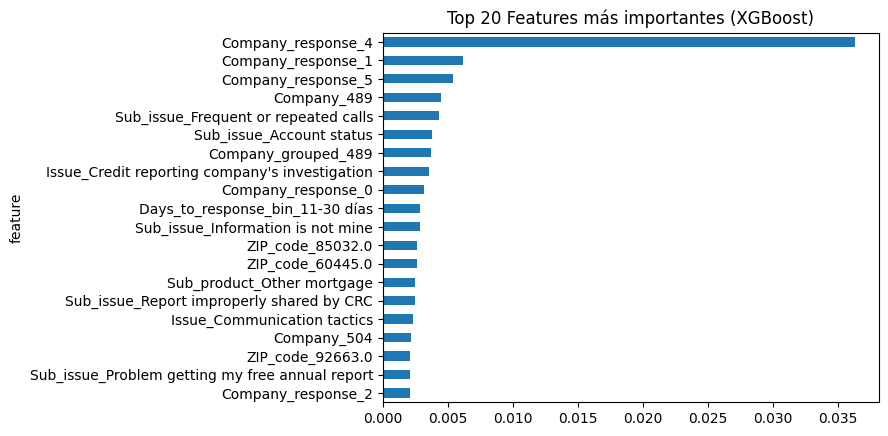

,feature,importance
1657,Company_response_4,0.036309
1654,Company_response_1,0.006138
1658,Company_response_5,0.005414
696,Company_489,0.004487
158,Sub_issue_Frequent or repeated calls,0.004284
142,Sub_issue_Account status,0.003781
1681,Company_grouped_489,0.003720
85,Issue_Credit reporting company's investigation,0.003538
1653,Company_response_0,0.003187
1695,Days_to_response_bin_11-30 días,0.002858


In [50]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd

# Cargar modelo final
final_model = joblib.load("../models/final_model_xgboost_predict_disputa.pkl")

# Extraer el clasificador XGBoost dentro del pipeline
xgb_clf = final_model.named_steps["clf"]

# Importancia de features
importances = xgb_clf.feature_importances_
feature_names = final_model.named_steps["pre"].get_feature_names_out()

# DataFrame ordenado
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# Top 20 features
plt.figure(figsize=(10,6))
feat_imp.head(20).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 20 Features más importantes (XGBoost)")
plt.gca().invert_yaxis()
plt.show()

feat_imp.head(20)


In [ ]:
#!pip install shap -q

In [52]:
import shap

final_model = joblib.load("../models/final_model_xgboost_predict_disputa.pkl")
xgb_clf = final_model.named_steps["clf"]
pre = final_model.named_steps["pre"]

X_test_trans = pre.transform(X_test)
feat_names = pre.get_feature_names_out()


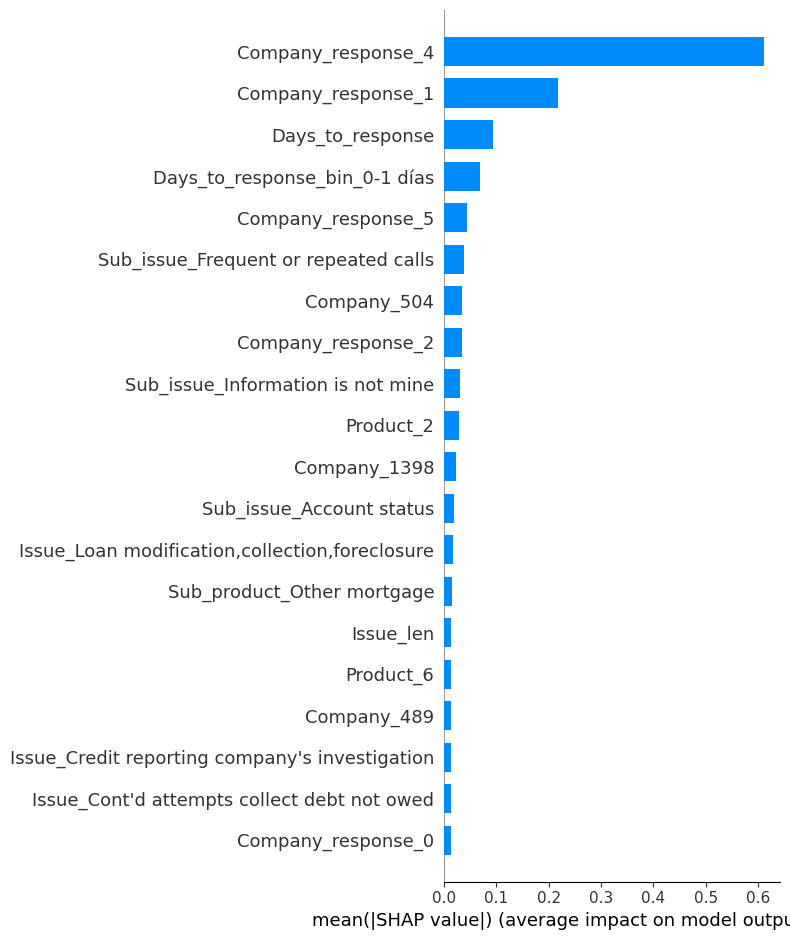

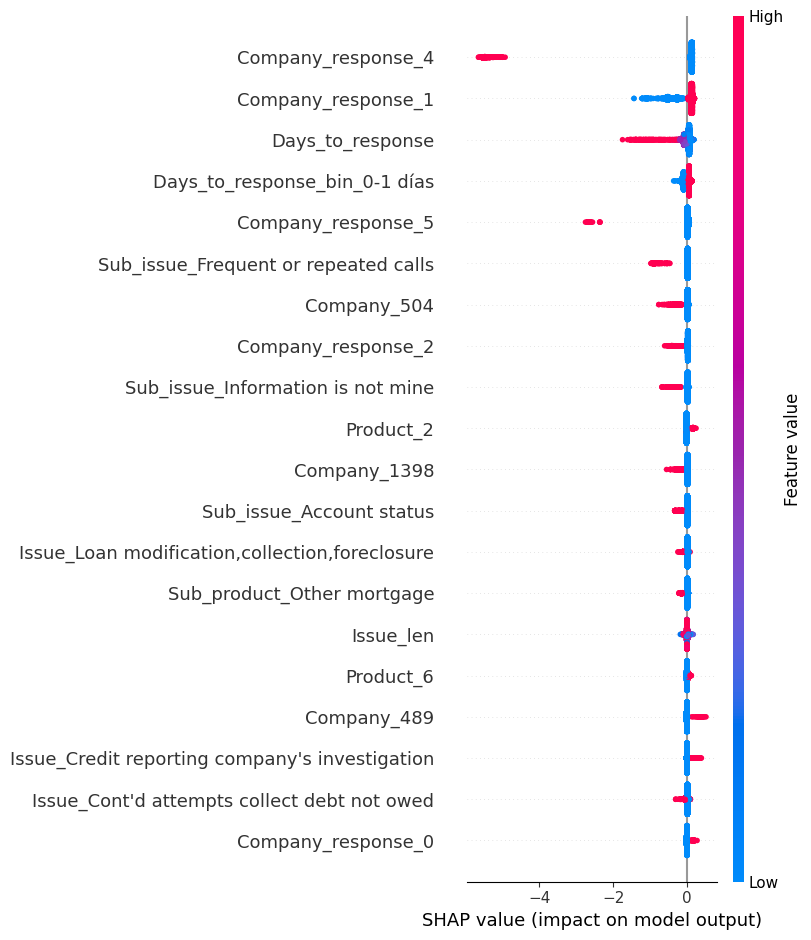

In [53]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test_trans)
expected_value = explainer.expected_value

shap.summary_plot(shap_values, features=X_test_trans, feature_names=feat_names, plot_type="bar", max_display=20, show=True)
shap.summary_plot(shap_values, features=X_test_trans, feature_names=feat_names, max_display=20, show=True)


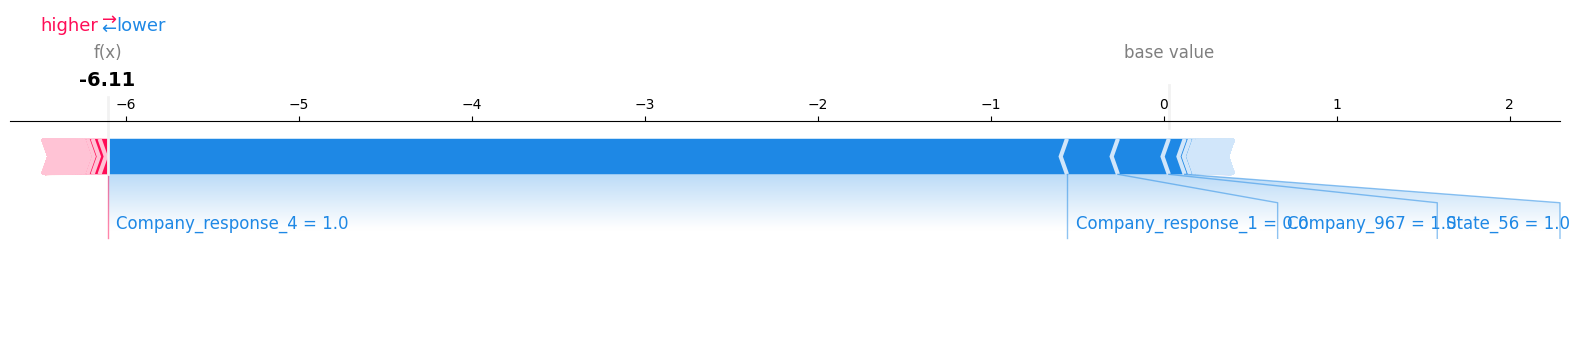

In [54]:
i = 0
shap.force_plot(expected_value, shap_values[i,:], X_test_trans[i,:], feature_names=feat_names, matplotlib=True)


In [55]:
# Cargar el modelo final
xgb_final = joblib.load("../models/final_model_xgboost_predict_disputa.pkl")

# Obtener nombres de features desde el preprocesador
feature_names = xgb_final.named_steps["pre"].get_feature_names_out()

# Obtener importancias desde el clasificador
importances = xgb_final.named_steps["clf"].feature_importances_

# Crear DataFrame ordenado
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# Guardar en CSV
output_path = "../models/top_feature_model_xgboost_predict_disputa.csv"
feat_imp.to_csv(output_path, index=False)

print(f"Archivo exportado: {output_path}")
feat_imp.head(15)


Archivo exportado: ../models/top_feature_model_xgboost_predict_disputa.csv


,feature,importance
1657,Company_response_4,0.036309
1654,Company_response_1,0.006138
1658,Company_response_5,0.005414
696,Company_489,0.004487
158,Sub_issue_Frequent or repeated calls,0.004284
142,Sub_issue_Account status,0.003781
1681,Company_grouped_489,0.003720
85,Issue_Credit reporting company's investigation,0.003538
1653,Company_response_0,0.003187
1695,Days_to_response_bin_11-30 días,0.002858


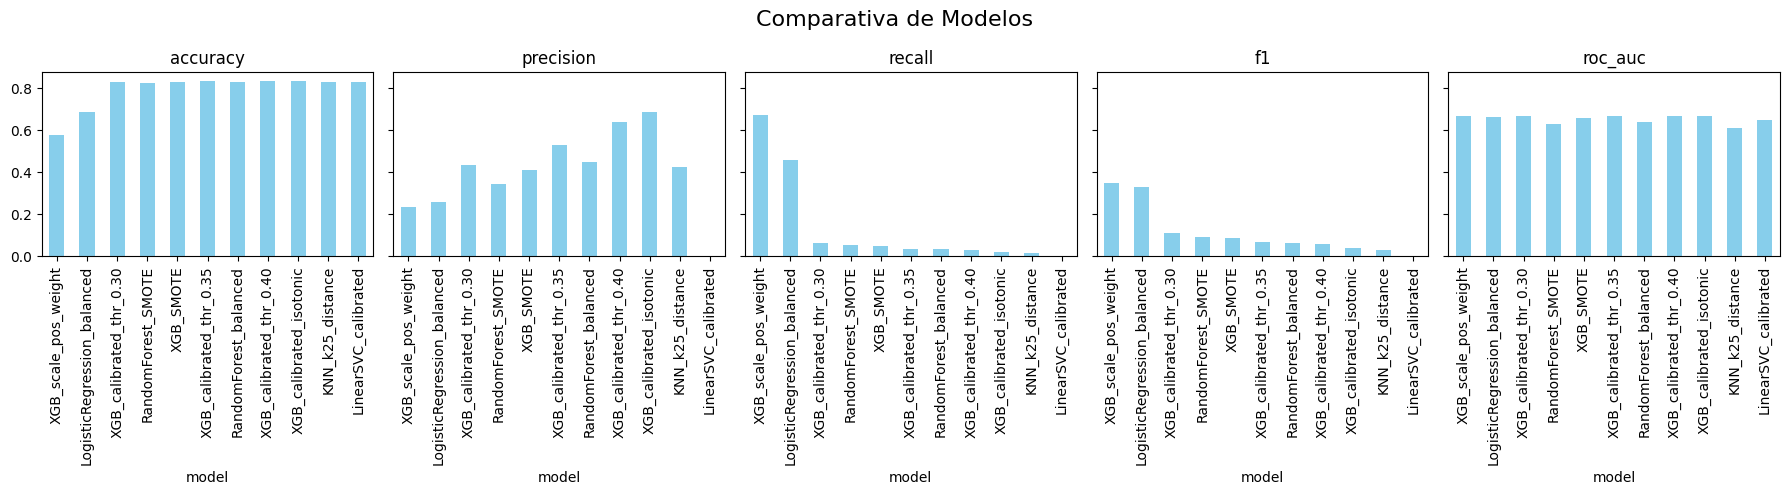

In [56]:
import matplotlib.pyplot as plt

metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

fig, axes = plt.subplots(1, len(metrics), figsize=(18, 5), sharey=True)

for i, m in enumerate(metrics):
    results_df.plot.bar(
        x="model", y=m, ax=axes[i], legend=False,
        title=m, rot=90, color="skyblue"
    )

plt.suptitle("Comparativa de Modelos", fontsize=16)
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

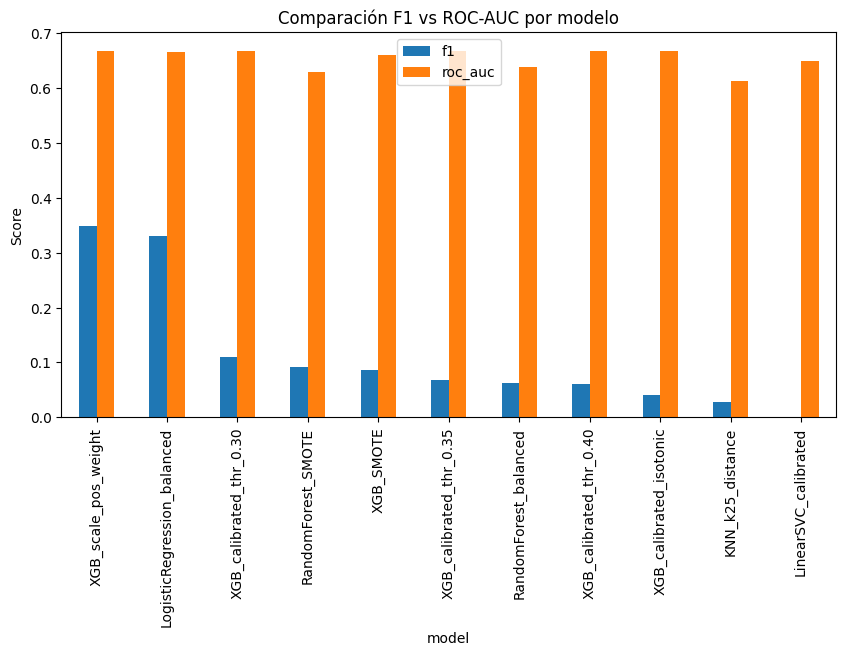

In [57]:
plt.figure(figsize=(10,5))
results_df.plot.bar(x="model", y=["f1","roc_auc"], rot=90, figsize=(10,5))
plt.title("Comparación F1 vs ROC-AUC por modelo")
plt.ylabel("Score")
plt.show()


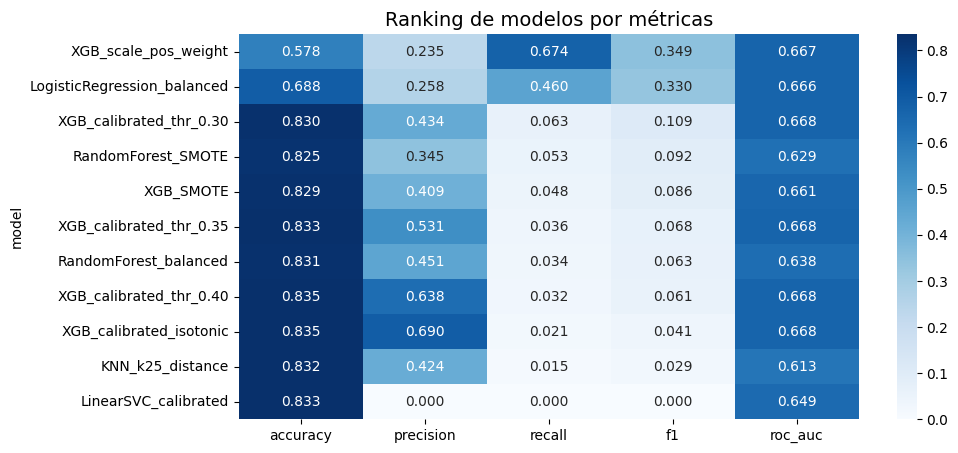

In [58]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.heatmap(
    results_df.set_index("model")[["accuracy","precision","recall","f1","roc_auc"]],
    annot=True, fmt=".3f", cmap="Blues"
)
plt.title("Ranking de modelos por métricas", fontsize=14)
plt.show()


In [60]:
results_sorted_f1 = results_df.sort_values("f1", ascending=False).reset_index(drop=True)
results_sorted_f1[["model","accuracy","precision","recall","f1","roc_auc"]]


,model,accuracy,precision,recall,f1,roc_auc
0,XGB_scale_pos_weight,0.578480,0.235011,0.674098,0.348518,0.666711
1,LogisticRegression_balanced,0.688388,0.257892,0.459660,0.330408,0.665615
2,XGB_calibrated_thr_0.30,0.829545,0.433824,0.062633,0.109462,0.668135
3,RandomForest_SMOTE,0.824751,0.344828,0.053079,0.091996,0.628707
4,XGB_SMOTE,0.829190,0.409091,0.047771,0.085551,0.661045
5,XGB_calibrated_thr_0.35,0.833452,0.531250,0.036093,0.067594,0.668135
6,RandomForest_balanced,0.831499,0.450704,0.033970,0.063179,0.638395
7,XGB_calibrated_thr_0.40,0.835050,0.638298,0.031847,0.060667,0.668135
8,XGB_calibrated_isotonic,0.834695,0.689655,0.021231,0.041195,0.668135
9,KNN_k25_distance,0.831854,0.424242,0.014862,0.028718,0.612661


C:\Users\QiliDev\AppData\Local\Temp\ipykernel_2368\567455036.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_sorted_f1, x="f1", y="model", palette="viridis")


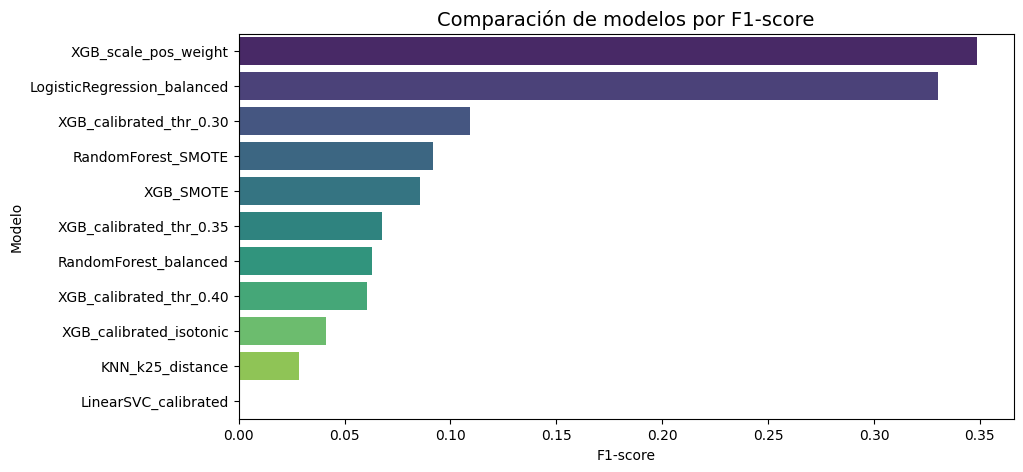

In [61]:
plt.figure(figsize=(10,5))
sns.barplot(data=results_sorted_f1, x="f1", y="model", palette="viridis")
plt.title("Comparación de modelos por F1-score", fontsize=14)
plt.xlabel("F1-score")
plt.ylabel("Modelo")
plt.show()


C:\Users\QiliDev\AppData\Local\Temp\ipykernel_2368\2061563210.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_sorted_f1, x="roc_auc", y="model", palette="mako")


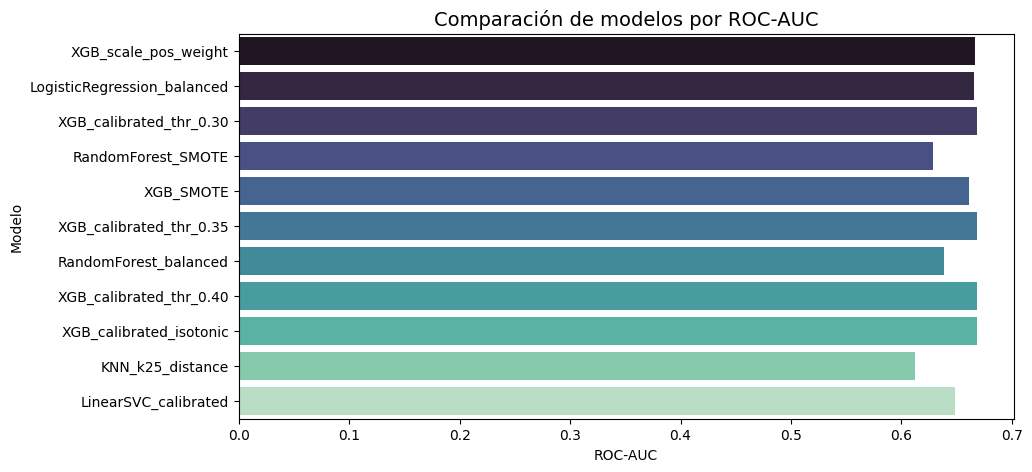

In [62]:
plt.figure(figsize=(10,5))
sns.barplot(data=results_sorted_f1, x="roc_auc", y="model", palette="mako")
plt.title("Comparación de modelos por ROC-AUC", fontsize=14)
plt.xlabel("ROC-AUC")
plt.ylabel("Modelo")
plt.show()


In [63]:
final_model_name = "XGB_scale_pos_weight"

highlight_df = results_sorted_f1.copy()
highlight_df["is_final"] = highlight_df["model"].apply(lambda x: "⭐" if x == final_model_name else "")

highlight_df_display = highlight_df[["is_final","model","accuracy","precision","recall","f1","roc_auc"]]
highlight_df_display


,is_final,model,accuracy,precision,recall,f1,roc_auc
0,⭐,XGB_scale_pos_weight,0.578480,0.235011,0.674098,0.348518,0.666711
1,,LogisticRegression_balanced,0.688388,0.257892,0.459660,0.330408,0.665615
2,,XGB_calibrated_thr_0.30,0.829545,0.433824,0.062633,0.109462,0.668135
3,,RandomForest_SMOTE,0.824751,0.344828,0.053079,0.091996,0.628707
4,,XGB_SMOTE,0.829190,0.409091,0.047771,0.085551,0.661045
5,,XGB_calibrated_thr_0.35,0.833452,0.531250,0.036093,0.067594,0.668135
6,,RandomForest_balanced,0.831499,0.450704,0.033970,0.063179,0.638395
7,,XGB_calibrated_thr_0.40,0.835050,0.638298,0.031847,0.060667,0.668135
8,,XGB_calibrated_isotonic,0.834695,0.689655,0.021231,0.041195,0.668135
9,,KNN_k25_distance,0.831854,0.424242,0.014862,0.028718,0.612661


C:\Users\QiliDev\AppData\Local\Temp\ipykernel_2368\2536260661.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_sorted_f1, x="f1", y="model", palette=colors)
c:\Users\QiliDev\git\QuiliDev_Proyecto_Final_ML\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


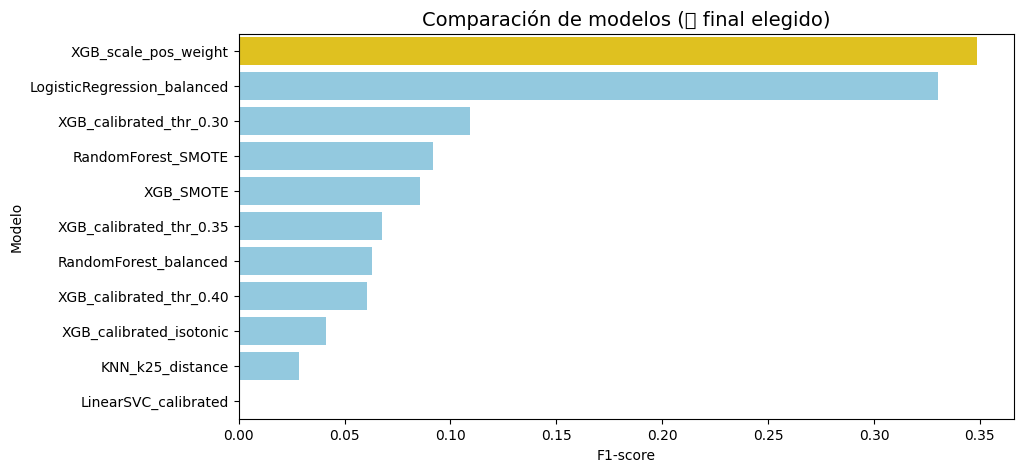

In [64]:
plt.figure(figsize=(10,5))
colors = ["gold" if m==final_model_name else "skyblue" for m in results_sorted_f1["model"]]
sns.barplot(data=results_sorted_f1, x="f1", y="model", palette=colors)
plt.title("Comparación de modelos (⭐ final elegido)", fontsize=14)
plt.xlabel("F1-score")
plt.ylabel("Modelo")
plt.show()


In [1]:
import yaml, os, joblib

cats = {
    "Product": list(le_product.classes_),
    "State": list(le_state.classes_),
    "Company": list(le_company.classes_),
    "Company_response": list(le_company_response.classes_),
}

os.makedirs("../models", exist_ok=True)
with open("../models/catalogs.yaml", "w", encoding="utf-8") as f:
    yaml.safe_dump(cats, f, allow_unicode=True)


NameError: name 'le_product' is not defined